In [2]:
%env CUDA_VISIBLE_DEVICES=4
%env GRB_LICENSE_FILE=/home/yppatel/gurobi.lic

env: CUDA_VISIBLE_DEVICES=4
env: GRB_LICENSE_FILE=/home/yppatel/gurobi.lic


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from ldcast import forecast
from ldcast.visualization import plots
import eval_data

In [4]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# consider forecast task at fixed T = 5 time steps into the future
T = 0

dir_name = "calibrations"
pred_weathers = []
for forecast_idx in range(128):
    with open(os.path.join(dir_name, f"{forecast_idx}.pkl"), "rb") as f:
        full_y_hats = pickle.load(f)
        pred_weathers.append(np.array([y_hat[T] for y_hat in full_y_hats]))

In [6]:
batch_size = 1
resolution = 256
data_iter = eval_data.get_data_iter(
    "validset", resolution=resolution, batch_size=batch_size
)

/home/yppatel/csi/ldcast/ldcast/features/transform.py:80: RuntimeWarning: divide by zero encountered in log10
  log_scale = np.log10(scale).astype(np.float32)


Loading cached sampler from ../cache/sampler_nowcaster256_valid.pkl.
Loading cached sampler from ../cache/sampler_nowcaster256_test.pkl.
Loading cached sampler from ../cache/sampler_nowcaster256_train.pkl.


/home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [7]:
full_data = list(data_iter)
xs = [x[0][0].cpu().numpy() for (x, _) in full_data]
true_weathers = [y[0,0,T].cpu().numpy() for (_, y) in full_data]

In [8]:
import osmnx as ox
G = ox.graph_from_place("Manhattan, New York City, New York", network_type="drive")

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [9]:
import networkx as nx
x_coords = list(nx.get_node_attributes(G, "x").values())
y_coords = list(nx.get_node_attributes(G, "y").values())

x_coord_range = (np.min(x_coords), np.max(x_coords))
y_coord_range = (np.min(y_coords), np.max(y_coords))

In [36]:
# adds an edge attribute "rain" corresponding to average rain along that edge (defined by mean between adjacent nodes)
def weight_by_rain(G, weather):
    xy_to_forecast = lambda forecast, x_coord, y_coord : forecast[
        min(int(((x_coord - x_coord_range[0]) / (x_coord_range[1] - x_coord_range[0])) * forecast.shape[0]), forecast.shape[0] - 1),
        min(int(((y_coord - y_coord_range[0]) / (y_coord_range[1] - y_coord_range[0])) * forecast.shape[1]), forecast.shape[1] - 1)
    ]
    node_predictions = [xy_to_forecast(weather, x_coord, y_coord) for x_coord, y_coord in zip(x_coords, y_coords)]
    rain_attributes = dict(zip(list(G), node_predictions))
    nx.set_node_attributes(G, rain_attributes, name="rain")

    edge_rain_attributes = {e : G.edges[e]["travel_time"] * np.exp(np.mean([G.nodes[e[0]]["rain"], G.nodes[e[1]]["rain"]])) for e in G.edges}
    nx.set_edge_attributes(G, edge_rain_attributes, name="rain")
    return G

In [37]:
import cv2

def route_by_weather(G, weather, ax):
    G = weight_by_rain(G, weather)

    orig = list(G)[1]
    dest = list(G)[120]
    route_time = ox.shortest_path(G, orig, dest, weight="travel_time")
    route_rain = ox.shortest_path(G, orig, dest, weight="rain")

    # prediction_resized = cv2.resize(weather, (500, 800))
    # axs[0].imshow(prediction_resized, origin="lower")
    gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False)
    gdf_edges.plot(ax=ax, cmap="viridis", column="rain")
    ox.plot_graph_routes(G, [route_time, route_rain], route_colors=["r", "y"], route_linewidth=1, node_size=2, ax=ax, show=False, close=False)

In [38]:
def route_by_true_pred(data_idx):
    true_weather = true_weathers[data_idx].copy()
    pred_weather = pred_weathers[data_idx].copy()

    threshold_mmh = 0.1
    true_weather[true_weather < threshold_mmh] = 0
    pred_weather[pred_weather < threshold_mmh] = 0

    cb = ((128,480), (160,608))
    true_weather = true_weather[cb[0][0]:cb[0][1], cb[1][0]:cb[1][1]]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
    
    sample_idx = 0 # which sample to viz from diffusion model
    route_by_weather(G, true_weather, axs[0])
    route_by_weather(G, pred_weather[sample_idx], axs[1])
    fig.set_tight_layout(True)

    axs[0].set_title("True Weather Routing")
    axs[1].set_title("Predicted Weather Routing")

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    return fig, axs

(<Figure size 1000x800 with 2 Axes>,
 array([<Axes: title={'center': 'True Weather Routing'}>,
        <Axes: title={'center': 'Predicted Weather Routing'}>],
       dtype=object))

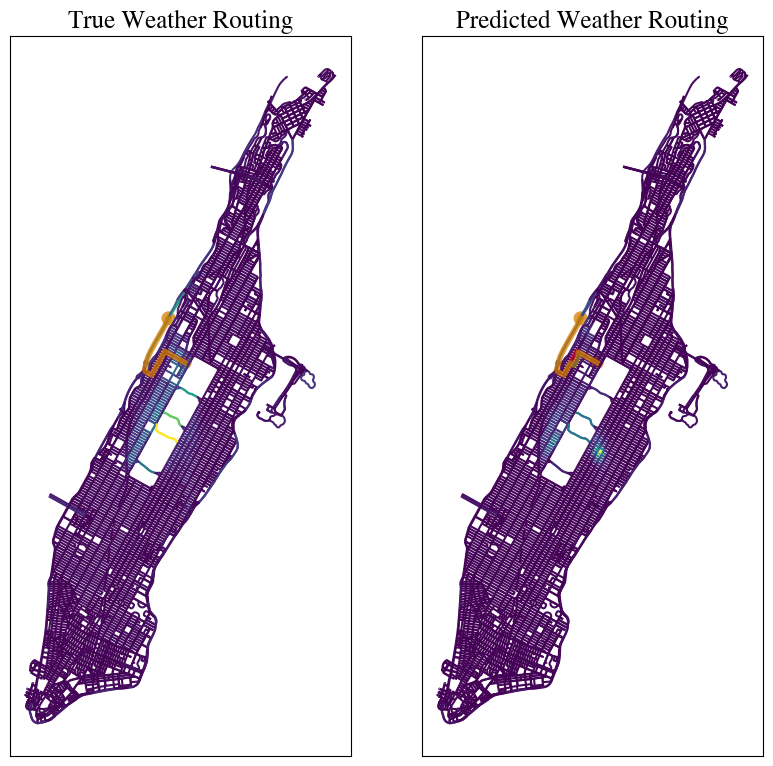

In [39]:
data_idx = 50
route_by_true_pred(data_idx)

In [40]:
true_weather = true_weathers[data_idx].copy()
threshold_mmh = 0.1
true_weather[true_weather < threshold_mmh] = 0
    
G = weight_by_rain(G, true_weather)

In [41]:
A = nx.incidence_matrix(G, oriented=True).todense()
c = np.array(list(nx.get_edge_attributes(G, name = 'rain').values()))

In [42]:
b = np.zeros(len(G.nodes)) # b entries: 1 for source, -1 for target, 0 o.w.
b[1] = -1
b[120] = 1 

In [43]:
from rsome import ro
from rsome import grb_solver as grb

model = ro.Model()

w = model.dvar(len(G.edges))

model.min(c @ w)
model.st(w <= 1)
model.st(w >= 0)
model.st(A @ w == b)

model.solve(grb)

Being solved by Gurobi...
Solution status: 2
Running time: 0.0273s


In [44]:
model.get()

215.49999999999997

In [47]:
nx.shortest_path_length(G, list(G)[1], list(G)[120], weight="rain")

215.5